# HW1

### Problem 5

In [1]:
import numpy as np
import csv
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

##### Read Data

In [2]:
data = []
with open('./hw1data/propublicaTrain.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if row:
            data.append(row)
data.pop(0)
data = np.asarray(data)
data = data.astype(np.int)
print('Shape of train samples:', data.shape)

Shape of train samples: (4167, 10)


In [3]:
test = []
with open('./hw1data/propublicaTest.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if row:
            test.append(row)
test.pop(0)
test = np.asarray(test)
test = test.astype(np.int)
print('Shape of test samples:', test.shape)

Shape of test samples: (2000, 10)


In [4]:
rec = data[:, 0]
data_0 = data[rec == 0][:,1:9]
data_1 = data[rec == 1][:,1:9]
print('No. of non-recidivism:', len(data_0))
print('No. of recidivism:', len(data_1))

No. of non-recidivism: 2267
No. of recidivism: 1900


##### MLE Based Classifier
Calculate the mean vector $\mu$ and covariance matrix $\Sigma$ to fit the Multivariate Gaussian distribution.<br>
Removed the last feature (totally correlated.)

Use the model to classify.

In [5]:
mean_0 = np.mean(data_0[:,:-1], axis=0)
mean_1 = np.mean(data_1[:,:-1], axis=0)
cov_0 = np.cov(data_0[:,:-1].T)
cov_1 = np.cov(data_1[:,:-1].T)

def MLE_classifier(x, indicator=True):
    f0 = multivariate_normal.pdf(x[:-1], mean=mean_0, cov=cov_0)
    f1 = multivariate_normal.pdf(x[:-1], mean=mean_1, cov=cov_1)
    if indicator:
        if f0 * len(data_0) > f1 * len(data_1):
            return 0
        else:
            return 1
        
    # ROC test
    else: 
        if math.isnan(f0*len(data_0)/(f0 * len(data_0) + f1 * len(data_1))) or math.isnan(f1*len(data_1)/(f0 * len(data_0) + f1 * len(data_1))):
            return [1*(f0 * len(data_0) > f1 * len(data_1)),1-1*(f0 * len(data_0) > f1 * len(data_1))]
        return [f0*len(data_0)/(f0 * len(data_0) + f1 * len(data_1)),f1*len(data_1)/(f0 * len(data_0) + f1 * len(data_1))]

##### kNN Classifier

In [6]:
def kNN_classifier(x, indicator=True):
    k = 5
    # calculate the distance 
    distance = []
    weight = [1, 0.01, 1, 1, 1, 0.1, 1, 1]
    bias =   [0, 0, 0, 0, 0, 0, 0, 0]
    for d in data:
        stack = np.stack((d[1:9], x))
        stack = stack * weight + bias
        # ------ L2 ------
        # dis = np.linalg.norm(stack, axis=0)
        # ------ L1 ------
        dis = np.sum(np.abs(stack[1] - stack[0]))
        # ----------------
        distance.append(np.sum(dis))
    
    sort = np.argsort(distance)
    points = data[sort[0:k]]
    count = np.sum(points[:,0])
    if indicator:
        if count < k / 2:
            return 0
        else:
            return 1
    else:#Roc test
        return [1-count/k,count/k]        

##### Naive-bayes Classifier
Use addictive smooth to age. Segmented the age of 5 years each.

In [7]:
# age-segmentation
smooth = 2
data_nb0 = data_0.copy()
data_nb1 = data_1.copy()
for i in range(len(data_nb0)):
    data_nb0[i, 1] //= smooth
for i in range(len(data_nb1)):
    data_nb1[i, 1] //= smooth
        
def naive_bayes_classifier(y, indicator=True):
    x = y.copy()
    x[1] //= smooth
    prior_0 = len(data_nb0) / len(data)
    prior_1 = len(data_nb1) / len(data)
    
    likelihood_0 = np.sum((data_nb0 == x) * 1, axis=0) / len(data_nb0)
    likelihood_1 = np.sum((data_nb1 == x) * 1, axis=0) / len(data_nb1)

    posterior_0 = np.prod(likelihood_0) * prior_0  
    posterior_1 = np.prod(likelihood_1) * prior_1 
    if indicator:
        if posterior_0 > posterior_1:
            return 0
        else:
            return 1
    # ROC test
    else:
        if math.isnan(posterior_0/(posterior_0+posterior_1)) or math.isnan(posterior_1/(posterior_0+posterior_1)):
            return [1*(posterior_0 > posterior_1),1-1*(posterior_0 > posterior_1)]
        return [posterior_0/(posterior_0+posterior_1),1-posterior_0/(posterior_0+posterior_1)]

##### Train Error

In [8]:
def classifier_train_error(function):
    true0 = true1 = false0 = false1 = 0
    for t in data:
        p = function(t[1:9])
        if t[0] == 0:
            if p == 0: true0  += 1
            if p == 1: false0 += 1
        if t[0] == 1:
            if p == 1: true1  += 1
            if p == 0: false1 += 1
                
    return (true0, true1, false0, false1, (true0+true1)/len(data))

In [165]:
print('Train Error MLE:', classifier_train_error(MLE_classifier))

Train Error MLE: (2076, 496, 191, 1404, 0.617230621550276)


In [61]:
print('Train Error kNN:', classifier_train_error(kNN_classifier))

Train Error kNN: (1745, 1305, 522, 595, 0.7319414446844252)


In [10]:
print('Train Error Bayes:', classifier_train_error(naive_bayes_classifier))

Train Error Bayes: (1758, 1054, 509, 846, 0.6748260139188865)


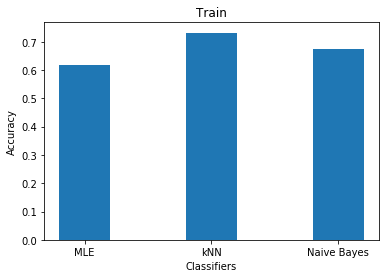

In [176]:
plt.bar([1,2,3], [0.617, 0.732, 0.675], width=0.4, tick_label=['MLE', 'kNN', 'Naive Bayes'])
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Train')
plt.show()

##### Test Classifiers

In [9]:
def classifier_test(function):
    true0 = true1 = false0 = false1 = 0
    pred = []
    for t in test:
        p = function(t[1:9])
        pred.append(p)
        if t[0] == 0:
            if p == 0: true0  += 1 
            if p == 1: false0 += 1
        elif t[0] == 1:
            if p == 1: true1  += 1
            if p == 0: false1 += 1
                
    return (pred, true0, true1, false0, false1, (true0+true1)/len(test))

In [166]:
pred_MLE, true0, true1, false0, false1, acc = classifier_test(MLE_classifier)
print('Test MLE:', (true0, true1, false0, false1, acc))

Test MLE: (1020, 240, 71, 669, 0.63)


kNN may take 3 minutes.

In [43]:
pred_kNN, true0, true1, false0, false1, acc = classifier_test(kNN_classifier)
print('Test kNN:', (true0, true1, false0, false1, acc))

Test kNN: (746, 533, 345, 376, 0.6395)


In [45]:
pred_naive, true0, true1, false0, false1, acc = classifier_test(naive_bayes_classifier)
print('Test Bayes:', (true0, true1, false0, false1, acc))

Test Bayes: (865, 508, 226, 401, 0.6865)
